In [1]:
import pandas as pd
import csv
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pickle

%matplotlib inline

font = 'Arial'
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = font
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = font
plt.rcParams['mathtext.it'] = font
plt.rcParams['mathtext.bf'] = font
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['ytick.minor.width'] = 0.5

linewidth = 2.5

In [2]:
def extract_score(file_name, seed_list, test_flag, ver2_flag=1):
    total_score, total_len = None, 0
    total_sample = None
    for seed in seed_list:
        if test_flag == 0:
            df = pd.read_csv(file_name + str(seed) + '/train.csv')
        else:
            df = pd.read_csv(file_name + str(seed) + '/eval.csv')
        if total_score is None:
            if ver2_flag == 1:
                total_score = df['true_episode_reward'].values
            elif ver2_flag == 2:
                total_score = df['noisy_feedback'].values / (df['total_feedback'].values + 1e-10)
            elif ver2_flag == 3:
                total_score = df['labeled_feedback'].values / (df['total_feedback'].values + 1e-10)
            else:
                total_score = df['episode_reward'].values
            total_len = len(total_score)
            total_score = total_score.reshape(1, -1)
            total_sample = df['step'].values
            total_sample = total_sample.reshape(1, -1)
        else:
            if ver2_flag == 1:
                score = df['true_episode_reward'].values
            elif ver2_flag == 2:
                score = df['noisy_feedback'].values / (df['total_feedback'].values + 1e-10)
            elif ver2_flag == 3:
                score = df['labeled_feedback'].values / (df['total_feedback'].values + 1e-10)
            else:
                score = df['episode_reward'].values
            temp_len = len(score)
            score = score.reshape(1, -1)
            sample = df['step'].values
            sample = sample.reshape(1, -1)
            
            if temp_len < total_len:
                total_len = temp_len
                total_sample = sample
                
            total_score = np.concatenate(
                (total_score[:, :total_len], 
                 score[0][:total_len].reshape(1, -1)), 
                axis=0)
            
    total_avg = np.average(total_score, axis=0)
    total_std = np.std(total_score, axis=0)
    return total_avg, total_std, total_sample, total_score

In [3]:
def save_dict(di_, filename_):
    with open(filename_, 'wb') as f:
        pickle.dump(di_, f)

def load_dict(filename_):
    with open(filename_, 'rb') as f:
        ret_di = pickle.load(f)
    return ret_di

In [4]:
def draw_figures(x_val, avg_val, std_val, ax, color, label, dash=False):
    if dash:
        ax.plot(x_val, avg_val, color=color[:3], 
                label=label, 
                linewidth=linewidth * 1.25, linestyle=':')
        
    else:
        ax.plot(x_val, avg_val, color=color[:3], 
                label=label, 
                linewidth=linewidth * 1.25)
    
    ax.fill_between(x_val, 
                    avg_val - std_val, 
                    avg_val + std_val, 
                    facecolor=color[:4], 
                    edgecolor=(0, 0, 0, 0))
    return ax

In [5]:
red_color = (247/255, 112/255, 136/255, 0.15)
blue_color = (128/255, 150/255, 244/255, 0.15)
dark_blue_color = (0/255, 83/255, 214/255, 0.15)
green_color = (51/255, 176/255, 122/255, 0.15)
purple_color = (204/255, 122/255, 244/255, 0.15)
orange_color = (255/255, 161/255, 0/255, 0.15)
black_color = (0/255, 0/255, 0/255, 0.15)
berkeley_blue_color = (0/255,50/255,98/255, 0.15)
cali_gold_color = (253/255,181/255,21/255, 0.15)
real_blue_color = (0/255, 0/255, 244/255, 0.15)
real_green_color = (0/255, 255/255, 0/255, 0.15)
real_red_color = (255/255, 0/255, 0/255, 0.15)
new_green_color = (92/255, 148/255, 13/255, 0.15) 
new_purple_color = (134/255, 46/255, 156/255, 0.15) 
new_yellow_color = (255/255, 224/255, 102/255, 0.15) 
deeppink_color = (255/255, 20/255, 147/255, 0.15)

color_list =[red_color, green_color, dark_blue_color,
             blue_color, purple_color, orange_color, 
             black_color,  
             real_red_color, real_green_color, real_blue_color, 
             new_green_color, new_purple_color, new_yellow_color]
color_max = len(color_list)

# Setup

In [6]:
domain_name = 'quadruped' # 'cartpole' 'cheetah'
task_name = 'walk' # 'swingup' 'run'
env_name = domain_name + '_' + task_name
score_thres = 0.8
arch = 'H1024_L2'

# Normal - SAC

In [7]:
root_dir = '/shared/kimin/2021/NeurIPS/bpref/SAC/'

seed_list = [12345, 23451, 34512, 45123, 51234, 67890, 78906, 89067, 90678, 6789]
lr_list = [0.0001]
sac_normal_avg, sac_normal_std, sac_normal_step = dict(), dict(), dict()
sac_normal_name_list = []
temp = 0.1

for lr in lr_list:
    key = 'sac: normal ' + str(lr)
    sac_normal_name_list.append(key)
    file_name = root_dir + env_name + '/' + arch + '_B1024_tau0.005'
    file_name += '/sac_sac_lr' + str(lr) +'_temp' + str(temp) + '_seed'
    total_avg, total_std, total_sample, _ = extract_score(file_name, seed_list, test_flag=1, ver2_flag=0)
    sac_normal_avg[key] = total_avg
    sac_normal_std[key] = total_std
    sac_normal_step[key] = total_sample

In [8]:
root_dir = '/shared/kimin/2021/NeurIPS/bpref/SAC_UNSUPER/'

seed_list = [12345, 23451, 34512, 45123, 51234, 67890, 78906, 89067, 90678, 6789]
lr_list = [0.0001]
sac_un_normal_avg, sac_un_normal_std, sac_un_normal_step = dict(), dict(), dict()
sac_un_normal_name_list = []
temp = 0.1

for lr in lr_list:
    key = 'sac: normal ' + str(lr)
    sac_un_normal_name_list.append(key)
    file_name = root_dir + env_name + '/' + arch + '_B1024_tau0.005'
    file_name += '/sac_unsup9000_topk5_sac_lr' + str(lr) +'_temp' + str(temp) + '_seed'
    total_avg, total_std, total_sample, _ = extract_score(file_name, seed_list, test_flag=1, ver2_flag=0)
    sac_un_normal_avg[key] = total_avg
    sac_un_normal_std[key] = total_std
    sac_un_normal_step[key] = total_sample

# PEBBLE

In [9]:
root_dir = '/shared/kimin/2021/NeurIPS/bpref/PEBBLE/'

seed_list = [12345, 23451, 34512, 45123, 51234, 67890, 78906, 89067, 90678, 6789]
lr = 0.0001

ori_interact = 30000
ori_num_feed = 200
ori_num_feed_2 = 100

t_margin, t_noise, t_thres = 0, 0, 0
recent_flag = False

fedd_teacher_option_list = [
    (ori_interact, 0, 2000, ori_num_feed, 10, 50, 0, 'o'), # disagree / oracle
    (ori_interact, 0, 1000, ori_num_feed_2, 10, 50, 0, 'o'), # disagree / oracle
    (ori_interact, 1, 2000, ori_num_feed, 10, 50, 0, 'o'), # disagree / oracle
    (ori_interact, 1, 1000, ori_num_feed_2, 10, 50, 0, 'o'), # disagree / oracle
    (ori_interact, 2, 2000, ori_num_feed, 10, 50, 0, 'o'), # disagree / oracle
    (ori_interact, 2, 1000, ori_num_feed_2, 10, 50, 0, 'o'), # disagree / oracle
    (ori_interact, 3, 2000, ori_num_feed, 10, 50, 0, 'o'), # disagree / oracle
    (ori_interact, 3, 1000, ori_num_feed_2, 10, 50, 0, 'o'), # disagree / oracle
    (ori_interact, 4, 2000, ori_num_feed, 10, 50, 0, 'o'), # disagree / oracle
    (ori_interact, 4, 1000, ori_num_feed_2, 10, 50, 0, 'o'), # disagree / oracle
    (ori_interact, 5, 2000, ori_num_feed, 10, 50, 0, 'o'), # disagree / oracle
    (ori_interact, 5, 1000, ori_num_feed_2, 10, 50, 0, 'o'), # disagree / oracle
    
    (ori_interact, 0, 2000, ori_num_feed, 10, 50, 0, 'mi'), # disagree / mistake
    (ori_interact, 0, 1000, ori_num_feed_2, 10, 50, 0, 'mi'), # disagree / mistake
    (ori_interact, 1, 2000, ori_num_feed, 10, 50, 0, 'mi'), # disagree / mistake
    (ori_interact, 1, 1000, ori_num_feed_2, 10, 50, 0, 'mi'), # disagree / mistake
    (ori_interact, 2, 2000, ori_num_feed, 10, 50, 0, 'mi'), # disagree / mistake
    (ori_interact, 2, 1000, ori_num_feed_2, 10, 50, 0, 'mi'), # disagree / mistake
    (ori_interact, 3, 2000, ori_num_feed, 10, 50, 0, 'mi'), # disagree / mistake
    (ori_interact, 3, 1000, ori_num_feed_2, 10, 50, 0, 'mi'), # disagree / mistake
    (ori_interact, 4, 2000, ori_num_feed, 10, 50, 0, 'mi'), # disagree / mistake
    (ori_interact, 4, 1000, ori_num_feed_2, 10, 50, 0, 'mi'), # disagree / mistake
    (ori_interact, 5, 2000, ori_num_feed, 10, 50, 0, 'mi'), # disagree / mistake
    (ori_interact, 5, 1000, ori_num_feed_2, 10, 50, 0, 'mi'), # disagree / mistake

    
    (ori_interact, 0, 2000, ori_num_feed, 10, 50, 0, 'e'), # disagree / uniform
    (ori_interact, 0, 1000, ori_num_feed_2, 10, 50, 0, 'e'), # disagree / rational (beta=1)
    (ori_interact, 1, 2000, ori_num_feed, 10, 50, 0, 'e'), # disagree / uniform
    (ori_interact, 1, 1000, ori_num_feed_2, 10, 50, 0, 'e'), # disagree / rational (beta=1)
    (ori_interact, 2, 2000, ori_num_feed, 10, 50, 0, 'e'), # disagree / uniform
    (ori_interact, 2, 1000, ori_num_feed_2, 10, 50, 0, 'e'), # disagree / rational (beta=1)
    (ori_interact, 3, 2000, ori_num_feed, 10, 50, 0, 'e'), # disagree / uniform
    (ori_interact, 3, 1000, ori_num_feed_2, 10, 50, 0, 'e'), # disagree / rational (beta=1)
    (ori_interact, 4, 2000, ori_num_feed, 10, 50, 0, 'e'), # disagree / uniform
    (ori_interact, 4, 1000, ori_num_feed_2, 10, 50, 0, 'e'), # disagree / rational (beta=1)
    (ori_interact, 5, 2000, ori_num_feed, 10, 50, 0, 'e'), # disagree / uniform
    (ori_interact, 5, 1000, ori_num_feed_2, 10, 50, 0, 'e'), # disagree / rational (beta=1)
    
    
    (ori_interact, 0, 2000, ori_num_feed, 10, 50, 0, 's'), # disagree / skip
    (ori_interact, 0, 1000, ori_num_feed_2, 10, 50, 0, 's'), # disagree / skip
    (ori_interact, 1, 2000, ori_num_feed, 10, 50, 0, 's'), # disagree / skip
    (ori_interact, 1, 1000, ori_num_feed_2, 10, 50, 0, 's'), # disagree / skip
    (ori_interact, 2, 2000, ori_num_feed, 10, 50, 0, 's'), # disagree / skip
    (ori_interact, 2, 1000, ori_num_feed_2, 10, 50, 0, 's'), # disagree / skip
    (ori_interact, 3, 2000, ori_num_feed, 10, 50, 0, 's'), # disagree / skip
    (ori_interact, 3, 1000, ori_num_feed_2, 10, 50, 0, 's'), # disagree / skip
    (ori_interact, 4, 2000, ori_num_feed, 10, 50, 0, 's'), # disagree / skip
    (ori_interact, 4, 1000, ori_num_feed_2, 10, 50, 0, 's'), # disagree / skip
    (ori_interact, 5, 2000, ori_num_feed, 10, 50, 0, 's'), # disagree / skip
    (ori_interact, 5, 1000, ori_num_feed_2, 10, 50, 0, 's'), # disagree / skip
    
    (ori_interact, 0, 2000, ori_num_feed, 10, 50, 0, 'my'), # disagree / myopic
    (ori_interact, 0, 1000, ori_num_feed_2, 10, 50, 0, 'my'), # disagree / myopic
    (ori_interact, 1, 2000, ori_num_feed, 10, 50, 0, 'my'), # disagree / myopic
    (ori_interact, 1, 1000, ori_num_feed_2, 10, 50, 0, 'my'), # disagree / myopic
    (ori_interact, 2, 2000, ori_num_feed, 10, 50, 0, 'my'), # disagree / myopic
    (ori_interact, 2, 1000, ori_num_feed_2, 10, 50, 0, 'my'), # disagree / myopic
    (ori_interact, 3, 2000, ori_num_feed, 10, 50, 0, 'my'), # disagree / myopic
    (ori_interact, 3, 1000, ori_num_feed_2, 10, 50, 0, 'my'), # disagree / myopic
    (ori_interact, 4, 2000, ori_num_feed, 10, 50, 0, 'my'), # disagree / myopic
    (ori_interact, 4, 1000, ori_num_feed_2, 10, 50, 0, 'my'), # disagree / myopic
    (ori_interact, 5, 2000, ori_num_feed, 10, 50, 0, 'my'), # disagree / myopic
    (ori_interact, 5, 1000, ori_num_feed_2, 10, 50, 0, 'my'), # disagree / myopic
    
    
    (ori_interact, 0, 2000, ori_num_feed, 10, 50, 0, 'n'), # disagree / rational (beta=1)
    (ori_interact, 0, 1000, ori_num_feed_2, 10, 50, 0, 'n'), # disagree / rational (beta=1)
    (ori_interact, 1, 2000, ori_num_feed, 10, 50, 0, 'n'), # disagree / rational (beta=1)
    (ori_interact, 1, 1000, ori_num_feed_2, 10, 50, 0, 'n'), # disagree / rational (beta=1)
    (ori_interact, 2, 2000, ori_num_feed, 10, 50, 0, 'n'), # disagree / rational (beta=1)
    (ori_interact, 2, 1000, ori_num_feed_2, 10, 50, 0, 'n'), # disagree / rational (beta=1)
    (ori_interact, 3, 2000, ori_num_feed, 10, 50, 0, 'n'), # disagree / rational (beta=1)
    (ori_interact, 3, 1000, ori_num_feed_2, 10, 50, 0, 'n'), # disagree / rational (beta=1)
    (ori_interact, 4, 2000, ori_num_feed, 10, 50, 0, 'n'), # disagree / rational (beta=1)
    (ori_interact, 4, 1000, ori_num_feed_2, 10, 50, 0, 'n'), # disagree / rational (beta=1)
    (ori_interact, 5, 2000, ori_num_feed, 10, 50, 0, 'n'), # disagree / rational (beta=1)
    (ori_interact, 5, 1000, ori_num_feed_2, 10, 50, 0, 'n'), # disagree / rational (beta=1)
]

new_pebble_avg, new_pebble_std, new_pebble_step = dict(), dict(), dict()
new_noise_avg, new_noise_std, new_noise_step = dict(), dict(), dict()

new_pebble_total = dict()

new_pebble_name_list = []
teacher_dir = ''
for interact, feed_type, max_feed, num_feed, large_batch, segment, schedule, teacher_index in fedd_teacher_option_list:
    if teacher_index == 'n':
        teacher_dir = '/teacher_b1_g1_m0_s0_e0'
    elif teacher_index == 'my':
        teacher_dir = '/teacher_b-1_g0.9_m0_s0_e0'
    elif teacher_index == 'mi':
        teacher_dir = '/teacher_b-1_g1_m0.1_s0_e0'
    elif teacher_index == 's':
        teacher_dir = '/teacher_b-1_g1_m0_s0.1_e0'
    elif teacher_index == 'o':
        teacher_dir = '/teacher_b-1_g1_m0_s0_e0'
    elif teacher_index == 'e':
        teacher_dir = '/teacher_b-1_g1_m0_s0_e0.1'

    key = 'PEBBLE [' + str(feed_type) + '] (num_feed='+ str(num_feed) 
    key += ', sch=' + str(schedule) + ', inter=' + str(interact)
    key += ', te=' + str(teacher_index)
    key += ', rec=' + str(recent_flag) + ' ,seg=' + str(segment) + ')'
    new_pebble_name_list.append(key)
    
    file_name = root_dir  + env_name + '/' + arch + '_lr' + str(lr)
    file_name += teacher_dir
    file_name += '/label_smooth_0.0/schedule_' + str(schedule)
    file_name += '/PEBBLE_init1000_unsup9000_inter' + str(interact)
    file_name += '_maxfeed' + str(max_feed)
    file_name += '_seg' + str(segment) + '_acttanh'
    file_name += '_Rlr0.0003_Rbatch' + str(num_feed)
    file_name += '_Rupdate50_en3_sample' + str(feed_type)
    file_name += '_large_batch' + str(large_batch) + '_seed'
    
    total_avg, total_std, total_sample, total_score  = extract_score(file_name, seed_list, test_flag=1)
    new_pebble_avg[key] = total_avg
    new_pebble_std[key] = total_std
    new_pebble_step[key] = total_sample
    new_pebble_total[key] = total_score

# Main PLOT

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


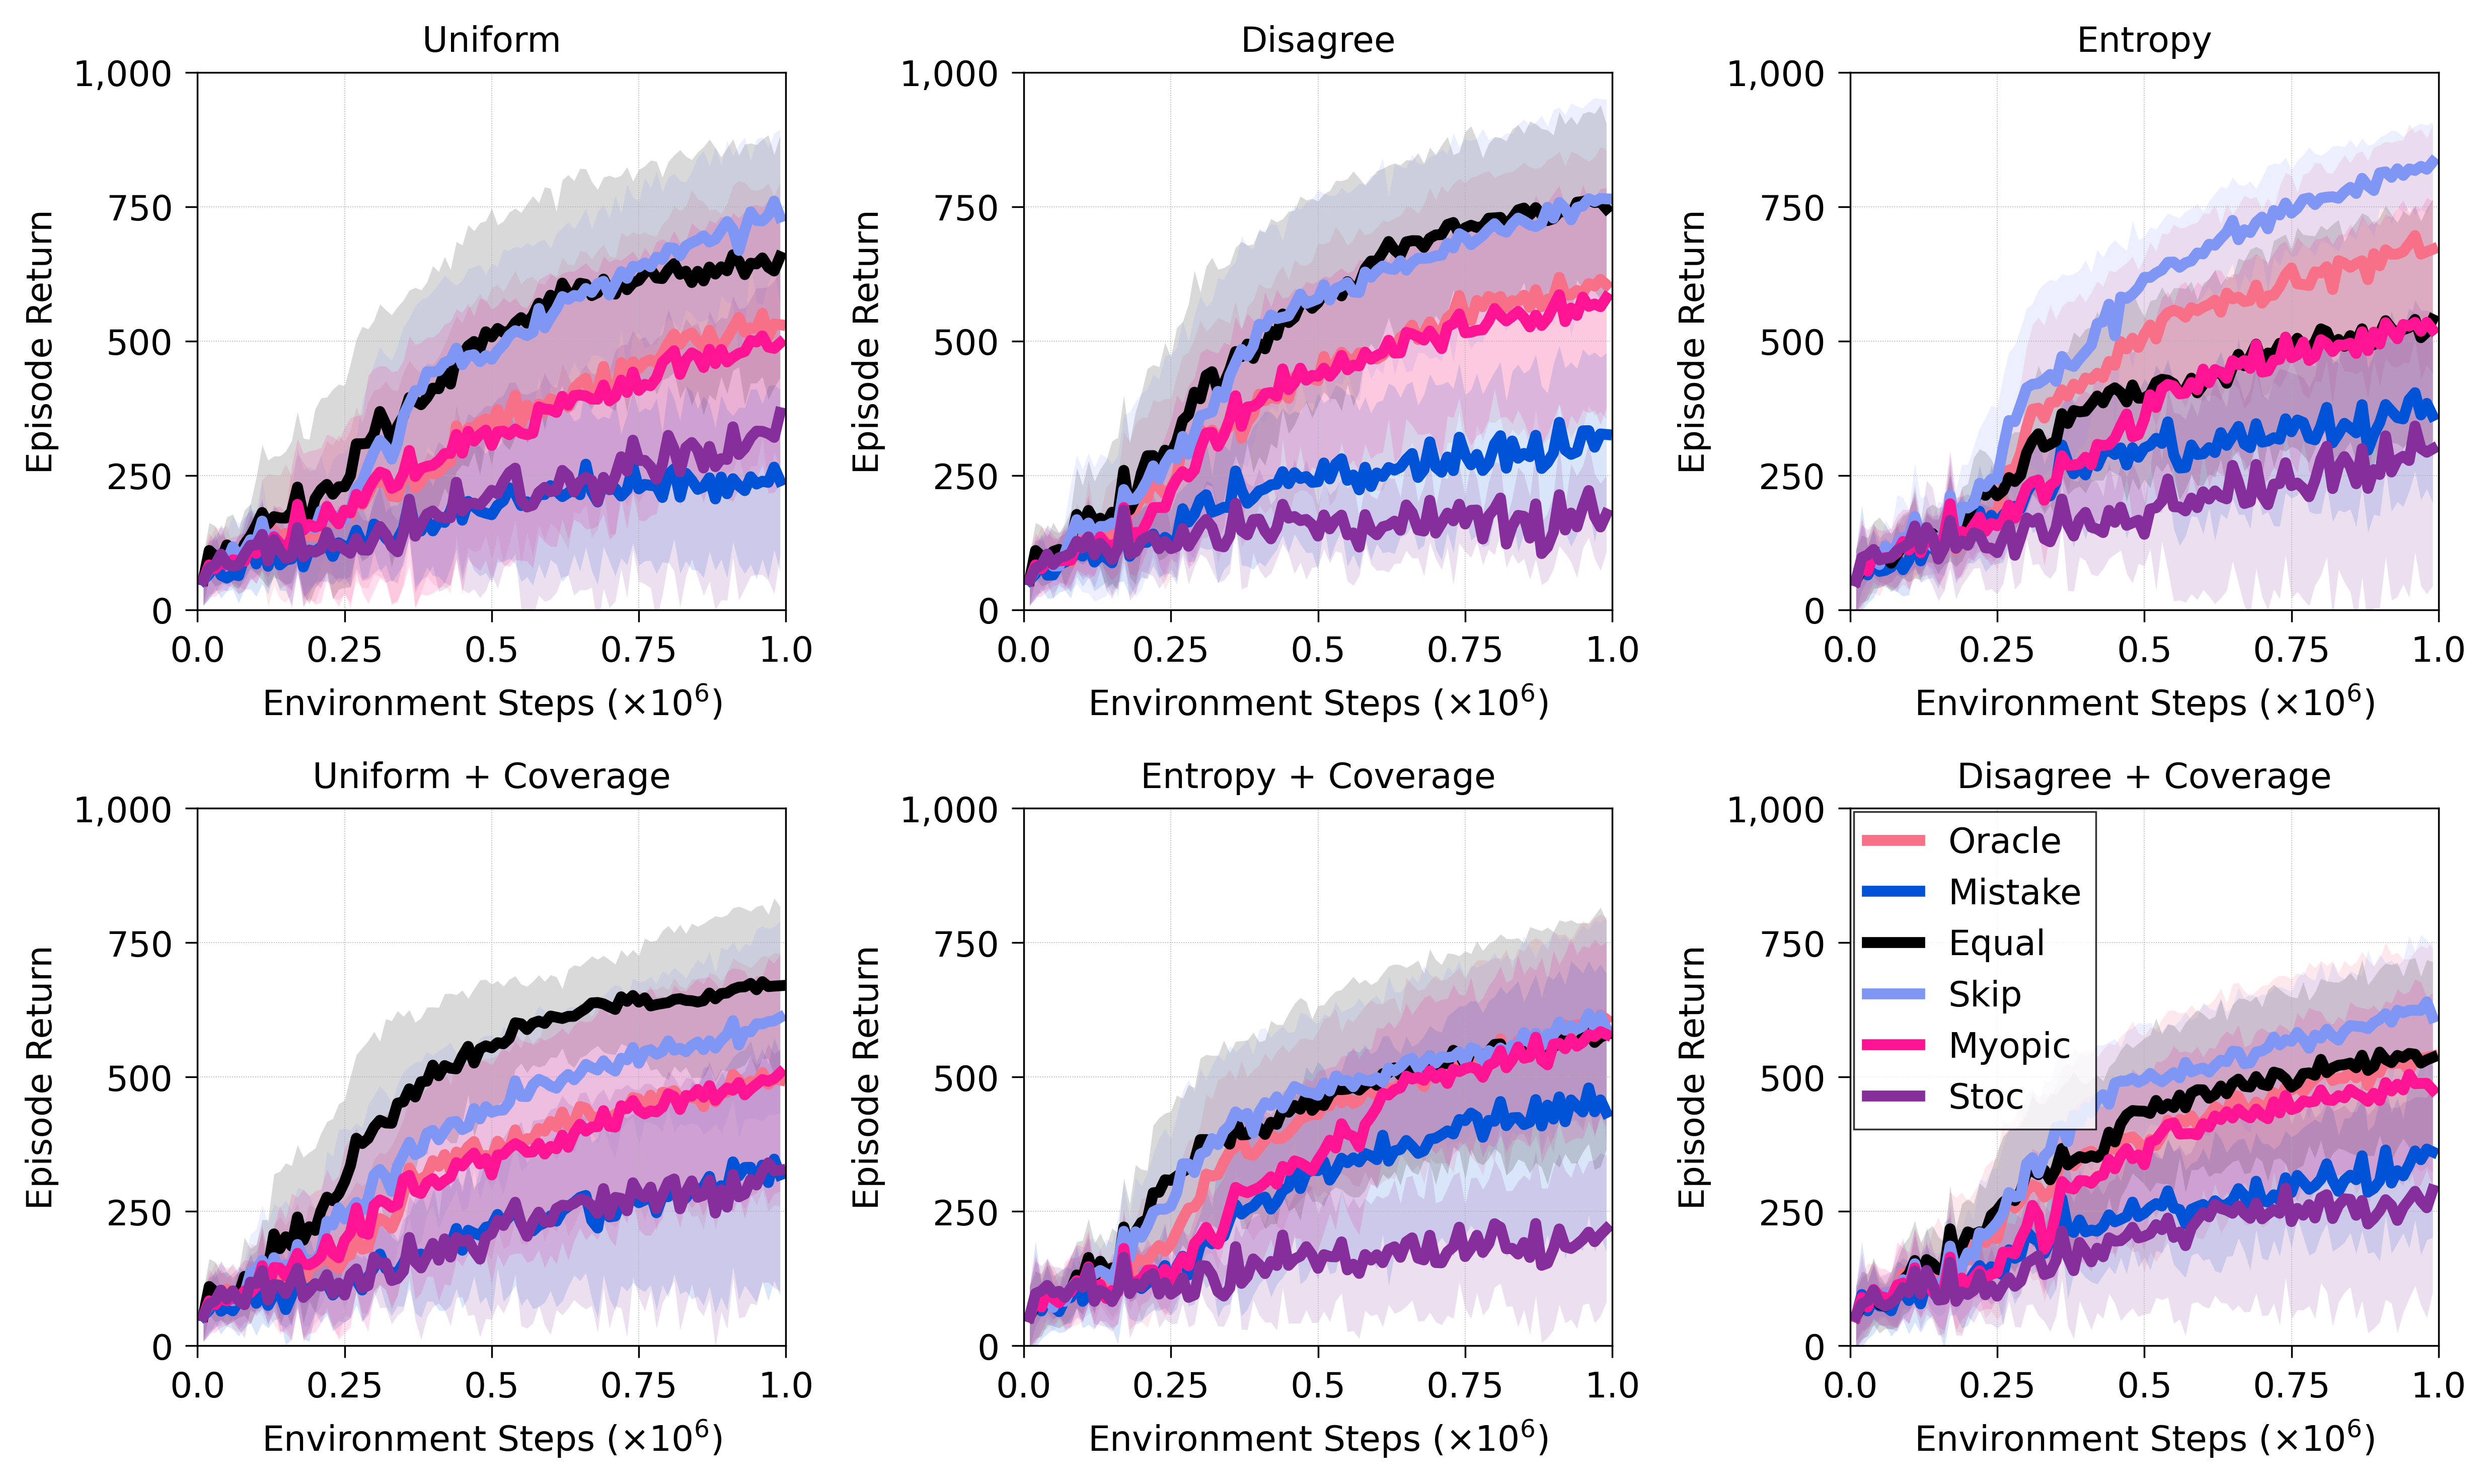

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6), dpi=500)
axes = np.reshape(axes, -1)

base = 1000000
ours_flag_list = ['[0]', '[1]', '[2]', 
                  '[3]', '[4]', '[5]']
ours_name_list = ['Uniform', 'Disagree', 'Entropy', 
                  'Uniform + Coverage', 'Entropy + Coverage', 'Disagree + Coverage']

len_ours = len(ours_flag_list)
sac_name = 'SAC with task reward (oracle)'
sac_color = color_list[0]
max_flag = 200

for index_, ax in enumerate(axes):
    for name in new_pebble_name_list:
        label = name
        score = new_pebble_avg[name]
        std = new_pebble_std[name]
        steps = new_pebble_step[name].reshape(-1)
        
        ours_flag = ours_flag_list[index_]
        ours_name = ours_name_list[index_]
        if 'te=o' in name and ours_flag in name:
            ours_color = color_list[0]
            if str(max_flag) in name:
                ax = draw_figures(steps/base, score, std, ax, 
                                  ours_color, 'Oracle')
            ax.set_title(ours_name, fontsize=10)
            
        if 'te=mi' in name and ours_flag in name:
            ours_color = color_list[2]
            if str(max_flag) in name:
                ax = draw_figures(steps/base, score, std, ax, 
                                  ours_color, 'Mistake')
            ax.set_title(ours_name, fontsize=10)
        
        if 'te=e' in name and ours_flag in name:
            ours_color = color_list[6]
            if str(max_flag) in name:
                ax = draw_figures(steps/base, score, std, ax, 
                                  ours_color, 'Equal')
            ax.set_title(ours_name, fontsize=10)
            
        if 'te=s' in name and ours_flag in name:
            ours_color = color_list[3]
            if str(max_flag) in name:
                ax = draw_figures(steps/base, score, std, ax, 
                                  ours_color, 'Skip')
            ax.set_title(ours_name, fontsize=10)
            
        if 'te=my' in name and ours_flag in name:
            ours_color = deeppink_color
            if str(max_flag) in name:
                ax = draw_figures(steps/base, score, std, ax, 
                                  ours_color, 'Myopic')
            ax.set_title(ours_name, fontsize=10)
            
            
        if 'te=n' in name and ours_flag in name:
            ours_color = new_purple_color
            if str(max_flag) in name:
                ax = draw_figures(steps/base, score, std, ax, 
                                  ours_color, 'Stoc')
            ax.set_title(ours_name, fontsize=10)
        
        
    ax.set_xlabel('Environment Steps ($\\times 10^6%$)', fontsize=10)
    ax.set_ylabel('Episode Return', fontsize=10)
    

    ax.grid(alpha=1.0, linestyle=':', linewidth=0.25)
    ax.tick_params(axis='both', which='major', labelsize=10)

    ax.set_yticks([0, 250, 500, 750,  1000])
    # ax.set_yticks([-250, 250, 750, 1250, 1750, 2250, 2750], minor=True)
    ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
    )

    ax.set_xticks([0, 0.25, 0.5, 0.75, 1])

    # NOTE: use xtick with 10^4 or xlabel with 10^4
    def set_xtick(x, p):
        return '{}'.format(x)

    ax.get_xaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(set_xtick)
    )
    ax.xaxis.major.formatter._useMathText = True

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1000)
    
    if 'Disagree + Coverage' in ours_name:
        leg = ax.legend(fancybox=False, fontsize=10,
                        edgecolor='black', borderaxespad=0.1, 
                        handlelength=1.5, loc='upper left')
        leg.get_frame().set_linewidth(0.5)

plt.tight_layout()
plt.savefig('./figure/table2_'+env_name+ '_feed_'+ str(max_flag) + '.pdf')

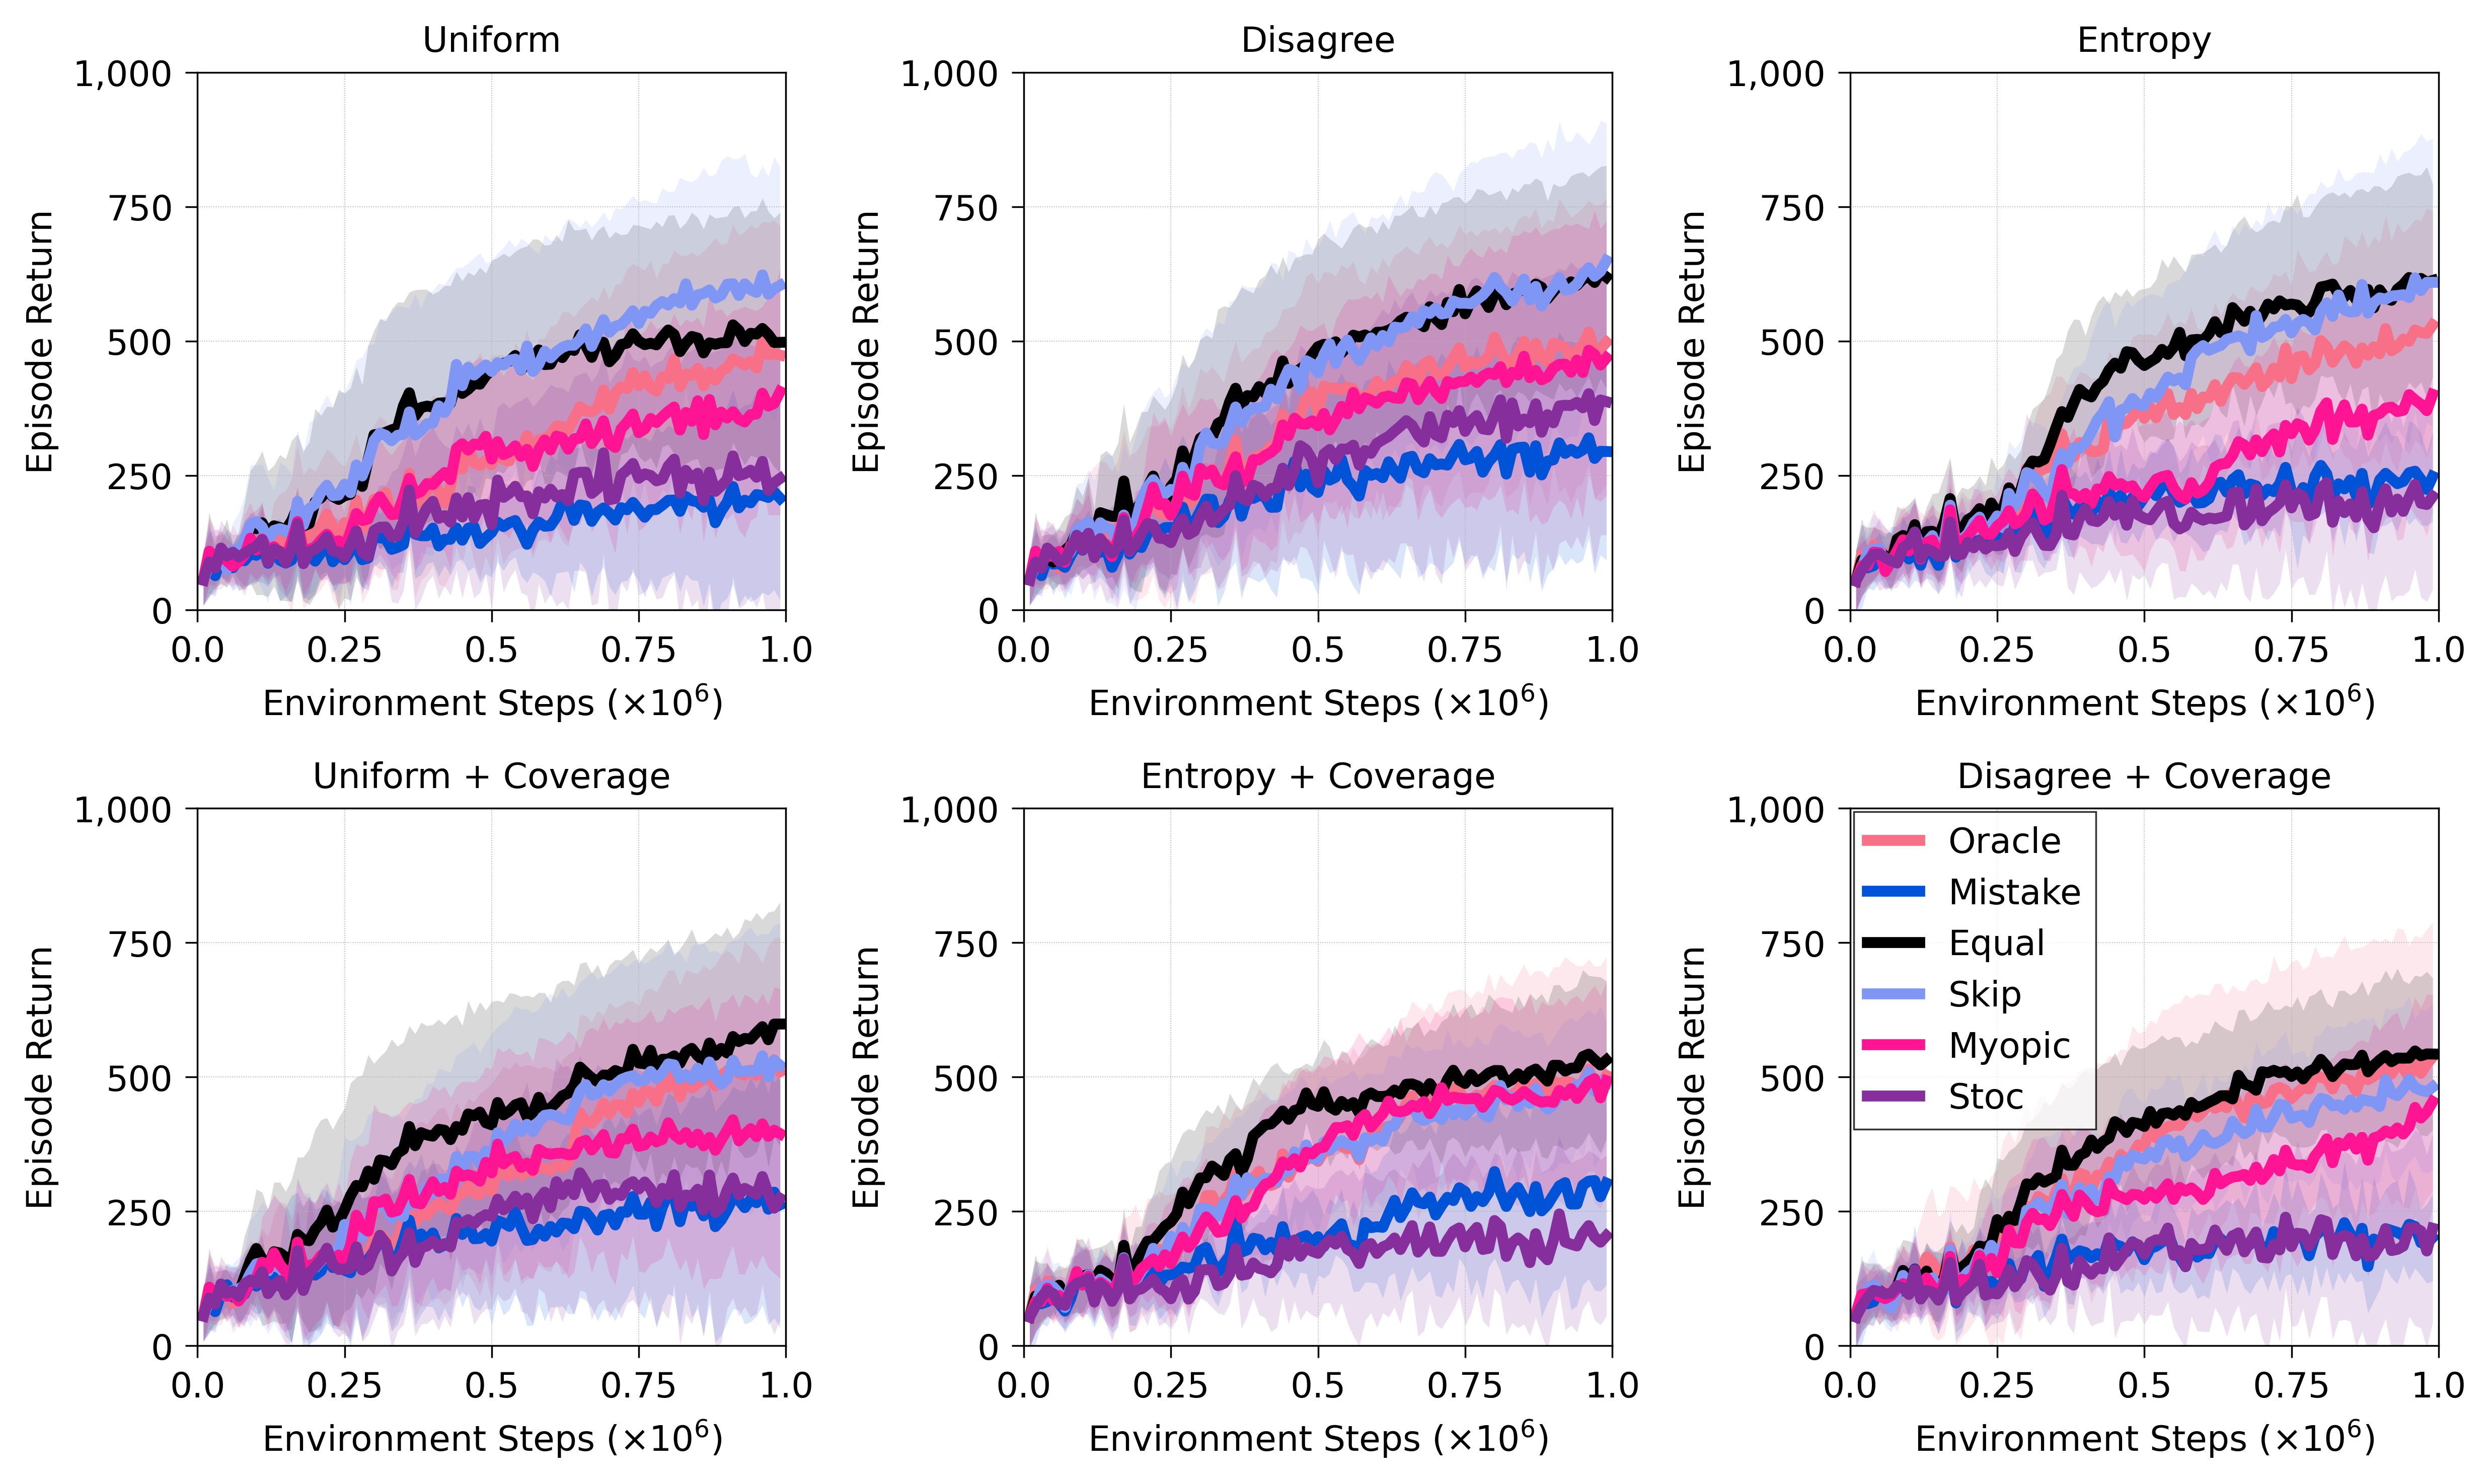

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6), dpi=500)
axes = np.reshape(axes, -1)

base = 1000000
ours_flag_list = ['[0]', '[1]', '[2]', 
                  '[3]', '[4]', '[5]']
ours_name_list = ['Uniform', 'Disagree', 'Entropy', 
                  'Uniform + Coverage', 'Entropy + Coverage', 'Disagree + Coverage']

len_ours = len(ours_flag_list)
sac_name = 'SAC with task reward (oracle)'
sac_color = color_list[0]
max_flag = 100

for index_, ax in enumerate(axes):
    for name in new_pebble_name_list:
        label = name
        score = new_pebble_avg[name]
        std = new_pebble_std[name]
        steps = new_pebble_step[name].reshape(-1)
        
        ours_flag = ours_flag_list[index_]
        ours_name = ours_name_list[index_]
        if 'te=o' in name and ours_flag in name:
            ours_color = color_list[0]
            if str(max_flag) in name:
                ax = draw_figures(steps/base, score, std, ax, 
                                  ours_color, 'Oracle')
            ax.set_title(ours_name, fontsize=10)
            
        if 'te=mi' in name and ours_flag in name:
            ours_color = color_list[2]
            if str(max_flag) in name:
                ax = draw_figures(steps/base, score, std, ax, 
                                  ours_color, 'Mistake')
            ax.set_title(ours_name, fontsize=10)
        
        if 'te=e' in name and ours_flag in name:
            ours_color = color_list[6]
            if str(max_flag) in name:
                ax = draw_figures(steps/base, score, std, ax, 
                                  ours_color, 'Equal')
            ax.set_title(ours_name, fontsize=10)
            
        if 'te=s' in name and ours_flag in name:
            ours_color = color_list[3]
            if str(max_flag) in name:
                ax = draw_figures(steps/base, score, std, ax, 
                                  ours_color, 'Skip')
            ax.set_title(ours_name, fontsize=10)
            
        if 'te=my' in name and ours_flag in name:
            ours_color = deeppink_color
            if str(max_flag) in name:
                ax = draw_figures(steps/base, score, std, ax, 
                                  ours_color, 'Myopic')
            ax.set_title(ours_name, fontsize=10)
            
            
        if 'te=n' in name and ours_flag in name:
            ours_color = new_purple_color
            if str(max_flag) in name:
                ax = draw_figures(steps/base, score, std, ax, 
                                  ours_color, 'Stoc')
            ax.set_title(ours_name, fontsize=10)
        
        
    ax.set_xlabel('Environment Steps ($\\times 10^6%$)', fontsize=10)
    ax.set_ylabel('Episode Return', fontsize=10)
    

    ax.grid(alpha=1.0, linestyle=':', linewidth=0.25)
    ax.tick_params(axis='both', which='major', labelsize=10)

    ax.set_yticks([0, 250, 500, 750,  1000])
    # ax.set_yticks([-250, 250, 750, 1250, 1750, 2250, 2750], minor=True)
    ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
    )

    ax.set_xticks([0, 0.25, 0.5, 0.75, 1])

    # NOTE: use xtick with 10^4 or xlabel with 10^4
    def set_xtick(x, p):
        return '{}'.format(x)

    ax.get_xaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(set_xtick)
    )
    ax.xaxis.major.formatter._useMathText = True

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1000)
    
    if 'Disagree + Coverage' in ours_name:
        leg = ax.legend(fancybox=False, fontsize=10,
                        edgecolor='black', borderaxespad=0.1, 
                        handlelength=1.5, loc='upper left')
        leg.get_frame().set_linewidth(0.5)

plt.tight_layout()
plt.savefig('./figure/table2_'+env_name+ '_feed_'+ str(max_flag) + '.pdf')

In [12]:
base = 1000000
ours_flag_list = ['[0]', 
                  '[2]', 
                  '[1]', 
                  '[3]', 
                  '[4]',
                  '[5]']
ours_name_list = ['Uniform', 
                  'Entropy',  
                  'Disagree', 
                  'Coverage', 
                  'Ent + Coverage', 
                  'Dis + Coverage']

len_ours = len(ours_flag_list)
sac_name = 'SAC with task reward (oracle)'
sac_color = color_list[0]
max_flag_1 = 200
max_flag_2 = 100
max_window = -10

for name in sac_normal_name_list:
    label = name
    score = sac_normal_avg[name]
    std = sac_normal_std[name]
    steps = sac_normal_step[name].reshape(-1)
    sac_max = np.max(score[max_window:])
    
for index_ in range(6):
    pebble_2K_list, pebble_1K_list = {}, {}
    for name in new_pebble_name_list:
        label = name
        score = new_pebble_avg[name]
        std = new_pebble_std[name]
        steps = new_pebble_step[name].reshape(-1)

        ours_flag = ours_flag_list[index_]
        ours_name = ours_name_list[index_]
        if 'te=o' in name and ours_flag in name:
            teacher_name = 'Oracle'
            if str(max_flag_1) in name:
                pebble_2K_list[teacher_name] = (np.max(score[max_window:])/sac_max)
            else:
                pebble_1K_list[teacher_name] = (np.max(score[max_window:])/sac_max)
                
        if 'te=mi' in name and ours_flag in name:
            teacher_name = 'Mistake'
            if str(max_flag_1) in name:
                pebble_2K_list[teacher_name] = (np.max(score[max_window:])/sac_max)
            else:
                pebble_1K_list[teacher_name] = (np.max(score[max_window:])/sac_max)
                
        if 'te=e' in name and ours_flag in name:
            teacher_name = 'Equal'
            if str(max_flag_1) in name:
                pebble_2K_list[teacher_name] = (np.max(score[max_window:])/sac_max)
            else:
                pebble_1K_list[teacher_name] = (np.max(score[max_window:])/sac_max)
                
        if 'te=s' in name and ours_flag in name:
            teacher_name = 'Skip'
            if str(max_flag_1) in name:
                pebble_2K_list[teacher_name] = (np.max(score[max_window:])/sac_max)
            else:
                pebble_1K_list[teacher_name] = (np.max(score[max_window:])/sac_max)
                
        if 'te=my' in name and ours_flag in name:
            teacher_name = 'Myopic'
            if str(max_flag_1) in name:
                pebble_2K_list[teacher_name] = (np.max(score[max_window:])/sac_max)
            else:
                pebble_1K_list[teacher_name] = (np.max(score[max_window:])/sac_max)
                
        if 'te=n' in name and ours_flag in name:
            teacher_name = 'Noisy'
            if str(max_flag_1) in name:
                pebble_2K_list[teacher_name] = (np.max(score[max_window:])/sac_max)
            else:
                pebble_1K_list[teacher_name] = (np.max(score[max_window:])/sac_max)
    print('\n' + ours_name + '====================')
    print('\n 2K')
    avg_per = []
    for temp in pebble_2K_list:
        avg_per.append(pebble_2K_list[temp])
        print(temp + ': '+str(pebble_2K_list[temp]))
    print('avg: '+str(np.average(avg_per)))
    print('\n 1K')
    avg_per = []
    for temp in pebble_1K_list:
        avg_per.append(pebble_1K_list[temp])
        print(temp + ': '+str(pebble_1K_list[temp]))    
    print('avg: '+str(np.average(avg_per)))


Uniform====================

 2K
Oracle: 0.746557490010606
Mistake: 0.35949859356327823
Equal: 0.8943796572374435
Skip: 1.029462020761367
Myopic: 0.6900394524079564
Noisy: 0.4967947809113431
avg: 0.7027886658153323

 1K
Oracle: 0.6769845498549704
Mistake: 0.31045542931601944
Equal: 0.7178973079348461
Skip: 0.8436533888369888
Myopic: 0.5496799619706826
Noisy: 0.3877576350666728
avg: 0.58107137883003

Entropy====================

 2K
Oracle: 0.9424929201425308
Mistake: 0.5469373189163333
Equal: 0.7314231554664287
Skip: 1.1280353438823925
Myopic: 0.7241836738266398
Noisy: 0.46299602070835205
avg: 0.7560114054904461

 1K
Oracle: 0.717629137493917
Mistake: 0.34928005703711157
Equal: 0.8370595577923918
Skip: 0.8362005495148207
Myopic: 0.542715151520864
Noisy: 0.31602921500879944
avg: 0.5998189447279841

Disagree====================

 2K
Oracle: 0.8374834269382652
Mistake: 0.472314850497374
Equal: 1.0330266530832979
Skip: 1.0359773151444727
Myopic: 0.7936862050199678
Noisy: 0.300429130462699

In [13]:
base = 1000000
ours_flag_list = ['[0]', 
                  '[2]', 
                  '[1]', 
                  '[3]', 
                  '[4]',
                  '[5]']
ours_name_list = ['Uniform', 
                  'Entropy',  
                  'Disagree', 
                  'Coverage', 
                  'Ent + Coverage', 
                  'Dis + Coverage']

len_ours = len(ours_flag_list)
sac_name = 'SAC with task reward (oracle)'
sac_color = color_list[0]
max_flag_1 = 200
max_flag_2 = 100
max_window = -10

for name in sac_un_normal_name_list:
    label = name
    score = sac_un_normal_avg[name]
    std = sac_un_normal_std[name]
    steps = sac_un_normal_step[name].reshape(-1)
    sac_max = np.max(score[max_window:])
    
for index_ in range(6):
    pebble_2K_list, pebble_1K_list = {}, {}
    for name in new_pebble_name_list:
        label = name
        score = new_pebble_avg[name]
        std = new_pebble_std[name]
        steps = new_pebble_step[name].reshape(-1)

        ours_flag = ours_flag_list[index_]
        ours_name = ours_name_list[index_]
        if 'te=o' in name and ours_flag in name:
            teacher_name = 'Oracle'
            if str(max_flag_1) in name:
                pebble_2K_list[teacher_name] = (np.max(score[max_window:])/sac_max)
            else:
                pebble_1K_list[teacher_name] = (np.max(score[max_window:])/sac_max)
                
        if 'te=mi' in name and ours_flag in name:
            teacher_name = 'Mistake'
            if str(max_flag_1) in name:
                pebble_2K_list[teacher_name] = (np.max(score[max_window:])/sac_max)
            else:
                pebble_1K_list[teacher_name] = (np.max(score[max_window:])/sac_max)
                
        if 'te=e' in name and ours_flag in name:
            teacher_name = 'Equal'
            if str(max_flag_1) in name:
                pebble_2K_list[teacher_name] = (np.max(score[max_window:])/sac_max)
            else:
                pebble_1K_list[teacher_name] = (np.max(score[max_window:])/sac_max)
                
        if 'te=s' in name and ours_flag in name:
            teacher_name = 'Skip'
            if str(max_flag_1) in name:
                pebble_2K_list[teacher_name] = (np.max(score[max_window:])/sac_max)
            else:
                pebble_1K_list[teacher_name] = (np.max(score[max_window:])/sac_max)
                
        if 'te=my' in name and ours_flag in name:
            teacher_name = 'Myopic'
            if str(max_flag_1) in name:
                pebble_2K_list[teacher_name] = (np.max(score[max_window:])/sac_max)
            else:
                pebble_1K_list[teacher_name] = (np.max(score[max_window:])/sac_max)
                
        if 'te=n' in name and ours_flag in name:
            teacher_name = 'Noisy'
            if str(max_flag_1) in name:
                pebble_2K_list[teacher_name] = (np.max(score[max_window:])/sac_max)
            else:
                pebble_1K_list[teacher_name] = (np.max(score[max_window:])/sac_max)
    print('\n' + ours_name + '====================')
    print('\n 2K')
    avg_per = []
    for temp in pebble_2K_list:
        avg_per.append(pebble_2K_list[temp])
        print(temp + ': '+str(pebble_2K_list[temp]))
    print('avg: '+str(np.average(avg_per)))
    print('\n 1K')
    avg_per = []
    for temp in pebble_1K_list:
        avg_per.append(pebble_1K_list[temp])
        print(temp + ': '+str(pebble_1K_list[temp]))    
    print('avg: '+str(np.average(avg_per)))


Uniform====================

 2K
Oracle: 0.6074299998733113
Mistake: 0.2925028997291225
Equal: 0.7277042188334544
Skip: 0.8376128074634577
Myopic: 0.5614445908014265
Noisy: 0.4042127468331364
avg: 0.5718178772556514

 1K
Oracle: 0.5508225830361655
Mistake: 0.25259935626313174
Equal: 0.5841108923329119
Skip: 0.6864312323316057
Myopic: 0.4472423138176137
Noisy: 0.3154956227364063
avg: 0.4727836667529725

Entropy====================

 2K
Oracle: 0.7668511561710285
Mistake: 0.4450107861825053
Equal: 0.5951160803784821
Skip: 0.9178161333319929
Myopic: 0.5892257391919282
Noisy: 0.3767126799521126
avg: 0.6151220958680083

 1K
Oracle: 0.583892697789184
Mistake: 0.28418867647927387
Equal: 0.6810662191287682
Skip: 0.6803672945249459
Myopic: 0.44157545645262924
Noisy: 0.25713441844918133
avg: 0.4880374604706638

Disagree====================

 2K
Oracle: 0.6814110965677722
Mistake: 0.3842948646509555
Equal: 0.8405131395073142
Skip: 0.8429139199956597
Myopic: 0.6457758683900939
Noisy: 0.2444415455

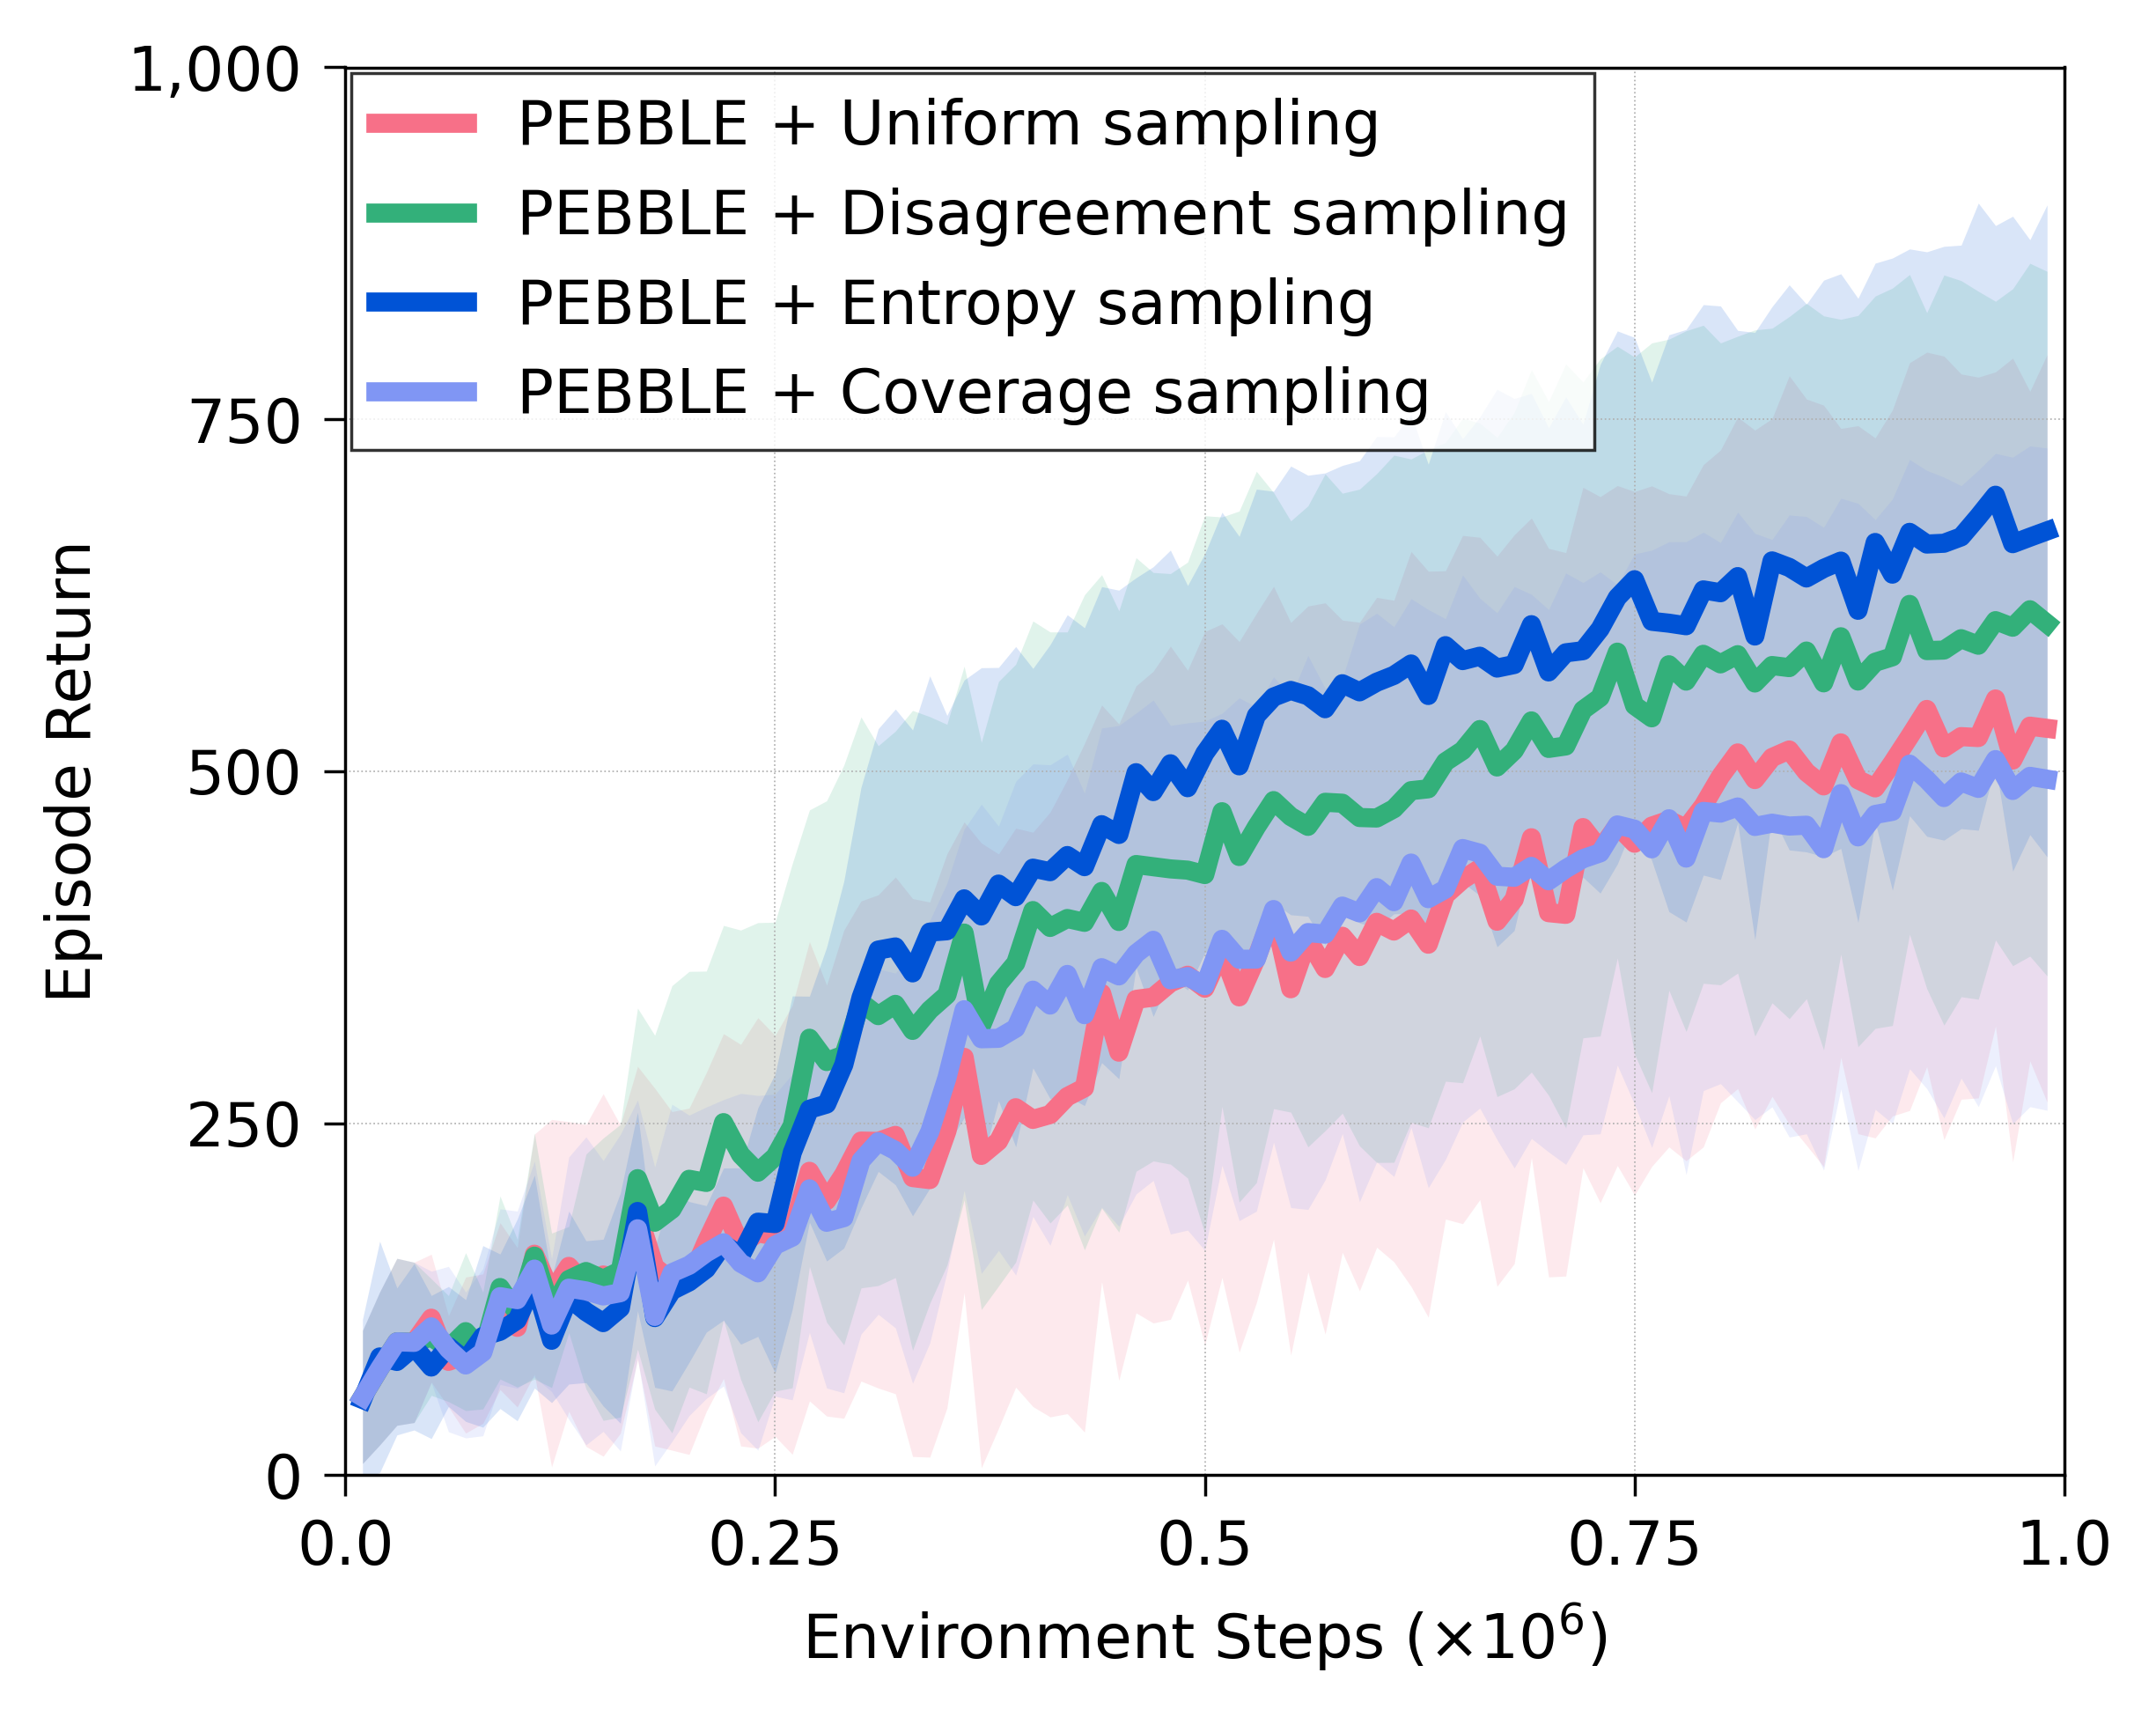

In [14]:
fig, axes = plt.subplots(1, 1, figsize=(5, 4), dpi=500)
axes = np.reshape(axes, -1)

base = 1000000
ours_flag_list = ['[0]', '[1]', '[2]', '[3]']
ours_name_list = ['Uniform', 'Disagreement', 'Entropy', 
                  'Coverage', 'Entropy + Coverage', 'Disagree + Coverage']

len_ours = len(ours_flag_list)
sac_name = 'SAC with task reward (oracle)'
sac_color = color_list[0]
max_flag = 200

for _, ax in enumerate(axes):
    for name in new_pebble_name_list:
        label = name
        score = new_pebble_avg[name]
        std = new_pebble_std[name]
        steps = new_pebble_step[name].reshape(-1)
        
        for index_ in range(len(ours_flag_list)):
            ours_flag = ours_flag_list[index_]
            ours_name = ours_name_list[index_]
            if 'te=o' in name and ours_flag in name:
                ours_color = color_list[index_]
                if str(max_flag) in name:
                    ax = draw_figures(steps/base, score, std, ax, 
                                      ours_color, "PEBBLE + " + ours_name + " sampling")
                    
    ax.set_xlabel('Environment Steps ($\\times 10^6%$)', fontsize=10)
    ax.set_ylabel('Episode Return', fontsize=10)
    

    ax.grid(alpha=1.0, linestyle=':', linewidth=0.25)
    ax.tick_params(axis='both', which='major', labelsize=10)

    ax.set_yticks([0, 250, 500, 750,  1000])
    # ax.set_yticks([-250, 250, 750, 1250, 1750, 2250, 2750], minor=True)
    ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
    )

    ax.set_xticks([0, 0.25, 0.5, 0.75, 1])

    # NOTE: use xtick with 10^4 or xlabel with 10^4
    def set_xtick(x, p):
        return '{}'.format(x)

    ax.get_xaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(set_xtick)
    )
    ax.xaxis.major.formatter._useMathText = True

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1000)
    
    leg = ax.legend(fancybox=False, fontsize=10,
                    edgecolor='black', borderaxespad=0.1, 
                    handlelength=1.5, loc='upper left')
    leg.get_frame().set_linewidth(0.5)

plt.tight_layout()
# plt.savefig('./table2_'+env_name+ '_feed_'+ str(max_flag) + '.pdf')

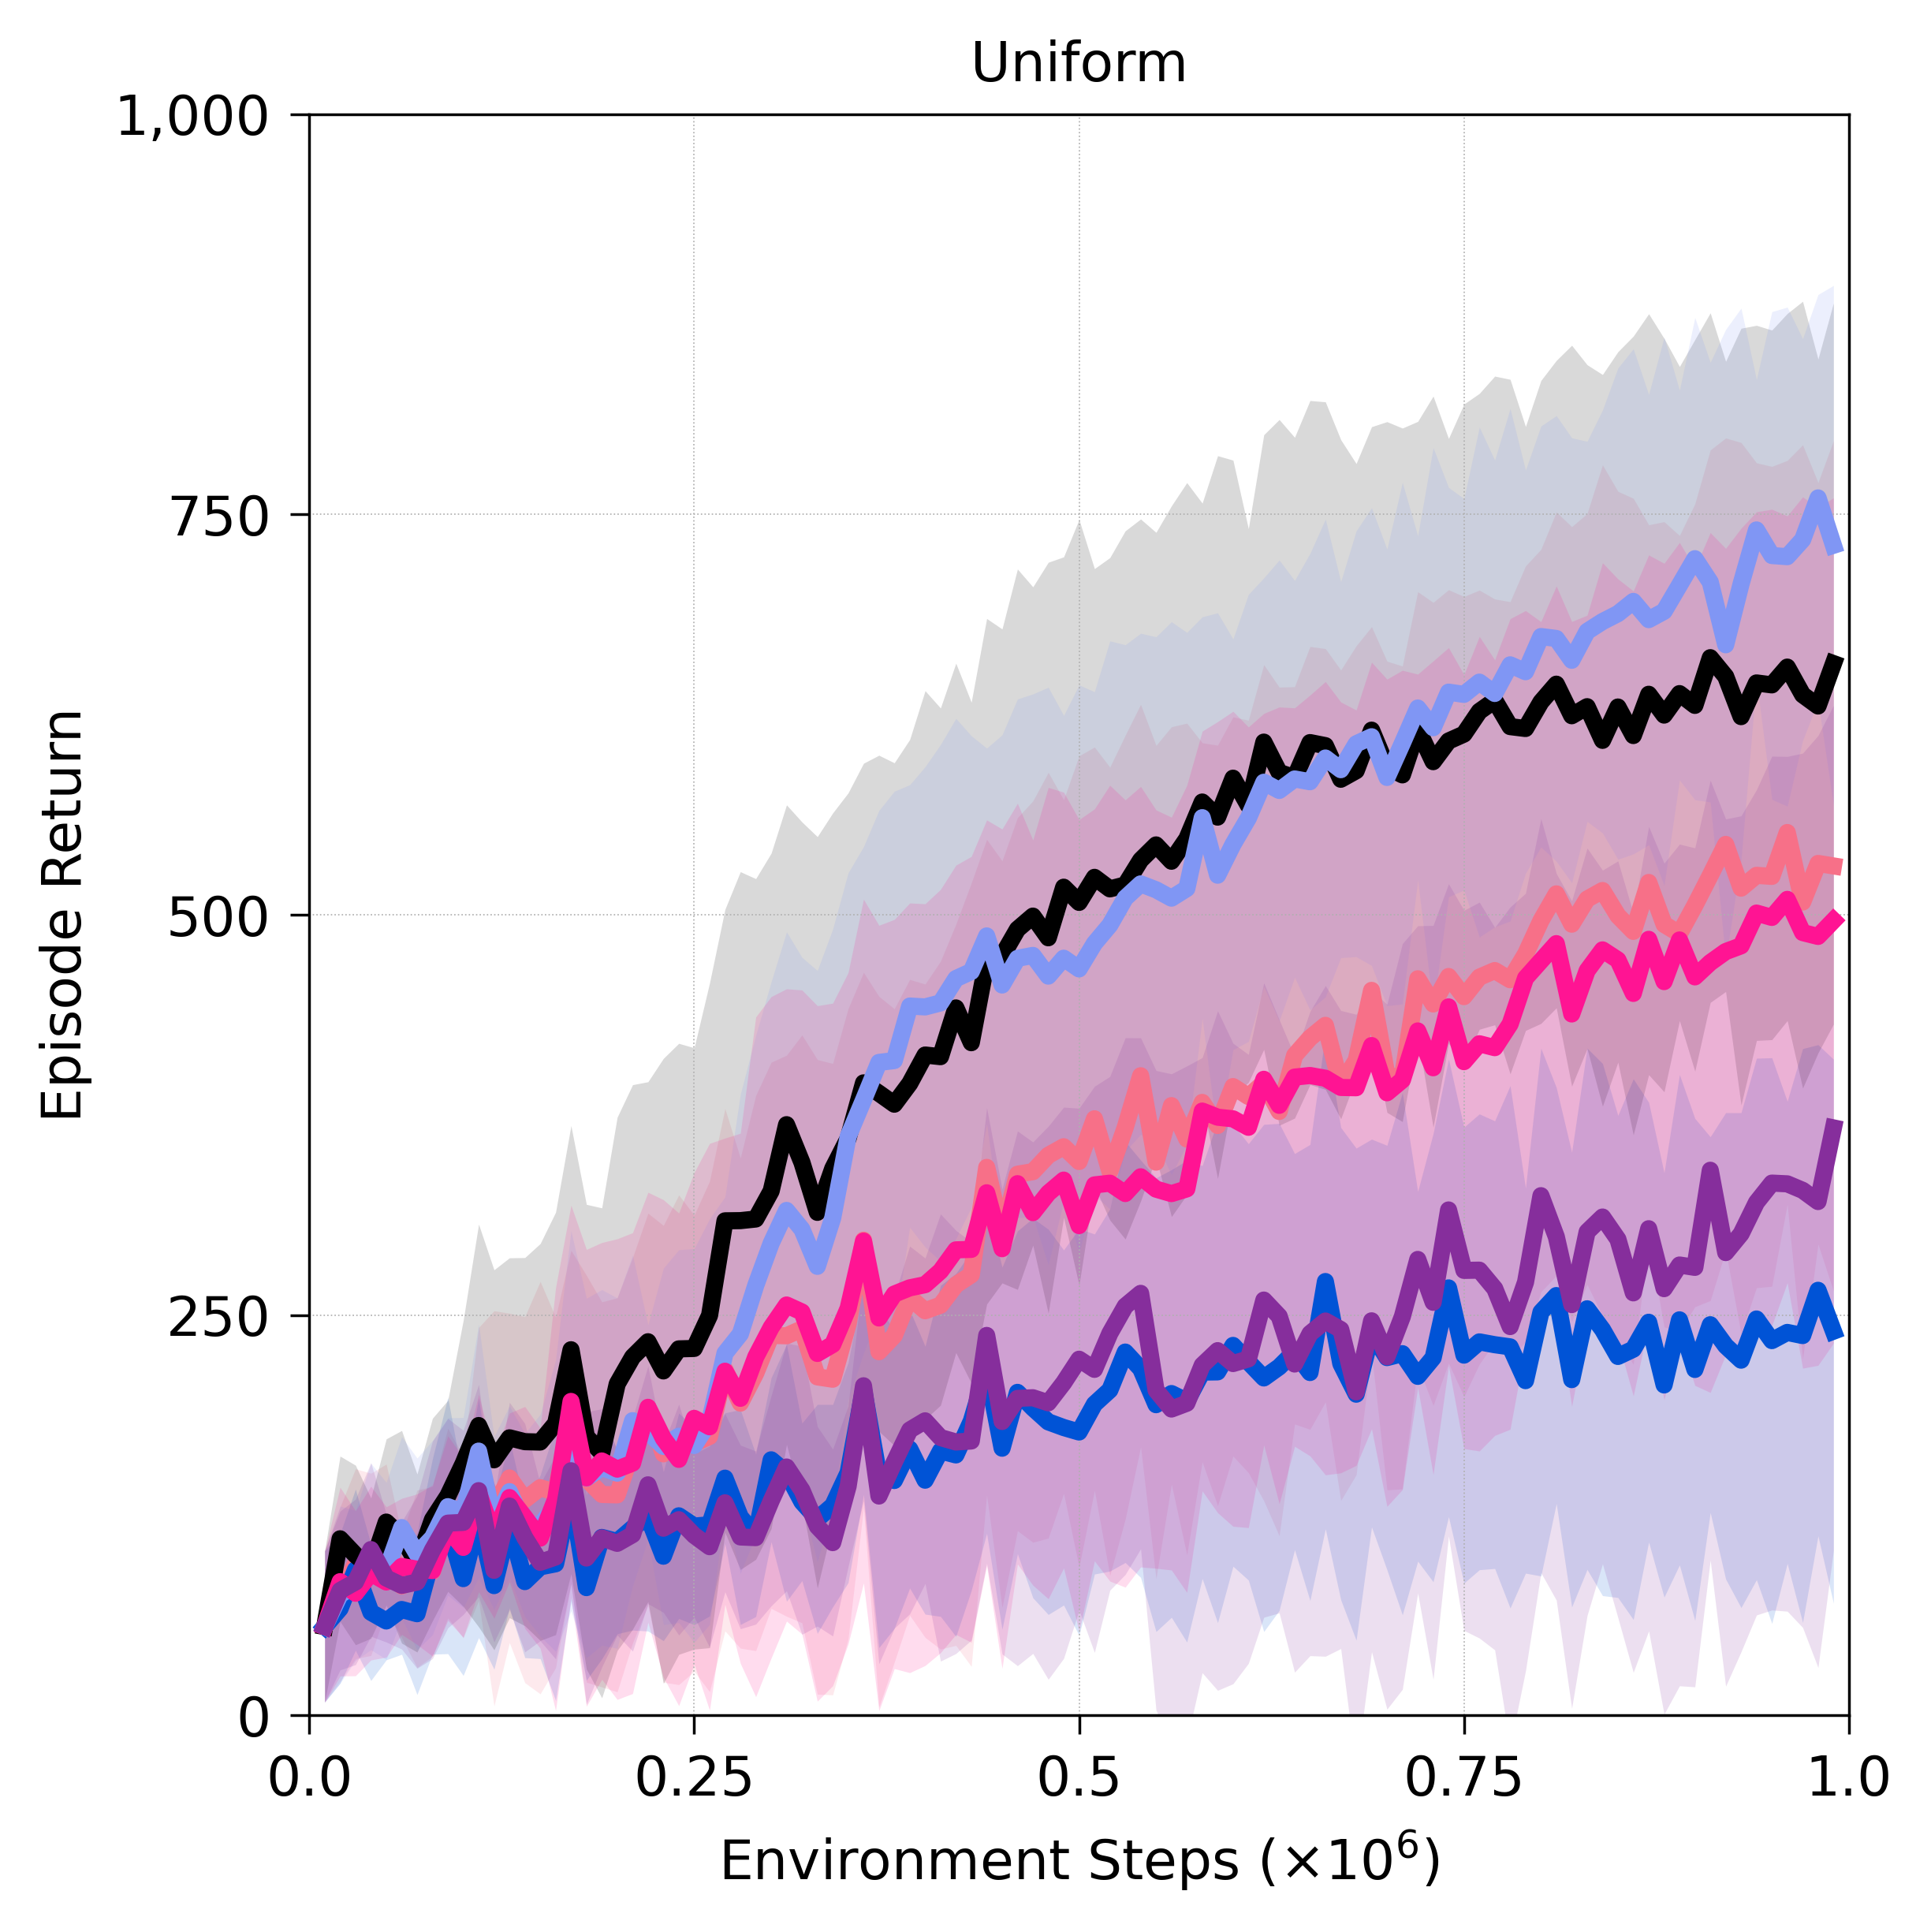

In [15]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=500)
axes = np.reshape(axes, -1)

base = 1000000
ours_flag_list = ['[0]', '[1]', '[2]', 
                  '[3]', '[4]', '[5]']
ours_name_list = ['Uniform', 'Disagree', 'Entropy', 
                  'Uniform + Coverage', 'Entropy + Coverage', 'Disagree + Coverage']

len_ours = len(ours_flag_list)
sac_name = 'SAC with task reward (oracle)'
sac_color = color_list[0]
max_flag = 200

for index_, ax in enumerate(axes):
    for name in new_pebble_name_list:
        label = name
        score = new_pebble_avg[name]
        std = new_pebble_std[name]
        steps = new_pebble_step[name].reshape(-1)
        
        ours_flag = ours_flag_list[index_]
        ours_name = ours_name_list[index_]
        if 'te=o' in name and ours_flag in name:
            ours_color = color_list[0]
            if str(max_flag) in name:
                ax = draw_figures(steps/base, score, std, ax, 
                                  ours_color, 'Oracle')
            ax.set_title(ours_name, fontsize=10)
            
        if 'te=mi' in name and ours_flag in name:
            ours_color = color_list[2]
            if str(max_flag) in name:
                ax = draw_figures(steps/base, score, std, ax, 
                                  ours_color, 'Mistake')
            ax.set_title(ours_name, fontsize=10)
        
        if 'te=e' in name and ours_flag in name:
            ours_color = color_list[6]
            if str(max_flag) in name:
                ax = draw_figures(steps/base, score, std, ax, 
                                  ours_color, 'Equal')
            ax.set_title(ours_name, fontsize=10)
            
        if 'te=s' in name and ours_flag in name:
            ours_color = color_list[3]
            if str(max_flag) in name:
                ax = draw_figures(steps/base, score, std, ax, 
                                  ours_color, 'Skip')
            ax.set_title(ours_name, fontsize=10)
            
        if 'te=my' in name and ours_flag in name:
            ours_color = deeppink_color
            if str(max_flag) in name:
                ax = draw_figures(steps/base, score, std, ax, 
                                  ours_color, 'Myopic')
            ax.set_title(ours_name, fontsize=10)
            
            
        if 'te=n' in name and ours_flag in name:
            ours_color = new_purple_color
            if str(max_flag) in name:
                ax = draw_figures(steps/base, score, std, ax, 
                                  ours_color, 'Noisy')
            ax.set_title(ours_name, fontsize=10)
        
        
    ax.set_xlabel('Environment Steps ($\\times 10^6%$)', fontsize=10)
    ax.set_ylabel('Episode Return', fontsize=10)
    

    ax.grid(alpha=1.0, linestyle=':', linewidth=0.25)
    ax.tick_params(axis='both', which='major', labelsize=10)

    ax.set_yticks([0, 250, 500, 750,  1000])
    # ax.set_yticks([-250, 250, 750, 1250, 1750, 2250, 2750], minor=True)
    ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
    )

    ax.set_xticks([0, 0.25, 0.5, 0.75, 1])

    # NOTE: use xtick with 10^4 or xlabel with 10^4
    def set_xtick(x, p):
        return '{}'.format(x)

    ax.get_xaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(set_xtick)
    )
    ax.xaxis.major.formatter._useMathText = True

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1000)
    
    if 'Disagree' in ours_name:
        leg = ax.legend(fancybox=False, fontsize=10,
                        edgecolor='black', borderaxespad=0.1, 
                        handlelength=1.5, loc='upper left')
        leg.get_frame().set_linewidth(0.5)

plt.tight_layout()
# plt.savefig('./table2_'+env_name+ '_feed_'+ str(max_flag) + '.pdf')

# Data generation - SAC

In [18]:
## Variables
max_window = -10
teacher_flag_list = ['te=o', 'te=mi', 'te=e', 'te=s', 'te=my', 'te=n']
teacher_name_list = ['Oracle', 'Mistake', 'Equal', 
                     'Skip', 'Myopic', 'Stoc']

ours_flag_list = ['[0]', 
                  '[2]', 
                  '[1]', 
                  '[3]', 
                  '[4]',
                  '[5]']
ours_name_list = ['Uniform', 
                  'Entropy',  
                  'Disagree', 
                  'Coverage', 
                  'Ent + Cover', 
                  'Dis + Cover']

## Extract score
for name in sac_normal_name_list:
    label = name
    score = sac_normal_avg[name]
    std = sac_normal_std[name]
    sac_max = np.max(score)

for name in sac_un_normal_name_list:
    label = name
    score = sac_un_normal_avg[name]
    sac_un_max = np.max(score)
    
PEBBLE_score = dict()
for index_ in range(len(teacher_flag_list)):
    teacher_flag = teacher_flag_list[index_]
    teacher_name = teacher_name_list[index_]
    
    for index_j in range(len(ours_flag_list)):
        our_flag = ours_flag_list[index_j]
        our_name = ours_name_list[index_j]
        for name in new_pebble_name_list:
            label = name
            if teacher_flag in name and our_flag in name:
                if 'num_feed=200' in name:
                    store_name = our_name + " (2K) (" + teacher_name + ")"
                if 'num_feed=100' in name:
                    store_name = our_name + " (1K) (" + teacher_name + ")"
                total_score = new_pebble_total[name]
                sac_norm = np.mean(total_score[:,max_window:-1], axis=1) / sac_max
                sac_un_norm = np.mean(total_score[:,max_window:-1], axis=1) / sac_un_max
    #             PEBBLE_score[store_name] = sac_norm.reshape(-1,1)
                PEBBLE_score[store_name] = sac_un_norm.reshape(-1,1)

In [19]:
save_dict(PEBBLE_score, './data/sampling_pebble.pkl')